<a href="https://www.kaggle.com/code/imranbukhari/dataset-walkthrough-and-audit?scriptVersionId=202381186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dataset Auditing and Inspection

This notebook demonstrates how to list and load the BTCUSD 1-minute interval dataset from multiple exchanges, generate statistics, and run a diagnostic function to detect data issues like missing values, duplicates, and time gaps. At the end is a simple plotting script to inspect the dataset visually at a glance. I thoroughly recommend using my diagnostic function, I developed it myself to identify time series dataset issue and it's been quite comprehensive for me diagnosing issues in my workflow.

The notebook is divided into the following sections:
1. Listing the available datasets.
2. Defining and using a diagnostic function to inspect the data.
3. Generating statistics about the datasets.
4. Plotting the datasets.

Finally, if you like my work or find it useful, I'm a new developer and would really appreciate any upvotes if my datasets or notebook were helpful for you.

## Listing Available Datasets

This block lists all available datasets in the `/kaggle/input` directory. These are the data files for BTCUSD 1-minute intervals from multiple exchanges.

In [1]:
"""
This notebook demonstrates how to list and load the files from the dataset, generate statistics, and plot the data.
You will learn how to interact with the Kaggle dataset structure and explore its contents with Python.
"""

import pandas as pd
import os

# This code lists all files under the "/kaggle/input" directory, which contains all input data files.
# These are the paths you will use to load any other these datasets.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_BitMEX.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Coinbase.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Binance.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_KuCoin.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Bitfinex.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Bitstamp.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Combined_Index.csv
/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_OKX.csv


## Defining the Diagnostic Function

I have written the below function `dataframe_diagnostics` to check for common data quality issues for time series datasets:
- NaNs (missing values).
- Time gaps, where we expect each row to be spaced by exactly 1 minute.
- Duplicate rows, which can skew analysis.

The function takes in a DataFrame and prints these diagnostics to give an overview of any potential issues in the dataset.
You are welcome to use this tool for other time series data projects.

In [9]:
def dataframe_diagnostics(df, max_gaps_to_print=5):
    """
    Diagnostic function to check for NaNs, duplicates, and time gaps in a 1-minute timeframe dataset.
    This function prints diagnostics by default. If there are more than 'max_gaps_to_print' gaps, it will
    print only the first 'max_gaps_to_print' and redact the rest for conciseness.
    
    Parameters:
    - df: The pandas DataFrame to diagnose.
    - max_gaps_to_print: The maximum number of gaps to print (default is 5).
    """
    
    # Convert 'Open time' to datetime format.
    # This ensures we can calculate time differences properly between rows.
    df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce')

    # Basic information gathering:
    # - Calculate the size of the dataset.
    # - Count total NaN (missing) values across the entire dataset.
    # - Identify which columns contain NaNs and how many rows have missing data.
    size = len(df)
    total_nans = df.isna().sum().sum()
    nan_cols = df.isna().sum()[df.isna().sum() > 0].index.tolist()
    rows_with_nans = df.isna().any(axis=1).sum()

    # Detect time gaps:
    # For a 1-minute timeframe dataset, we expect consecutive rows to have a 1-minute difference.
    # We calculate the actual time differences and flag any that are not exactly 1 minute.
    expected_diff = pd.Timedelta(minutes=1)
    time_diffs = df['Open time'].diff().dropna()
    discontinuities = time_diffs[time_diffs != expected_diff].index.tolist()

    # Capture details of detected time gaps:
    # For each gap, record the start time, end time, and the size of the gap.
    gap_details = []
    if len(discontinuities) > 0:
        for gap_index in discontinuities:
            gap_start_index = gap_index - 1
            gap_end_index = gap_index
            gap_start_time = df['Open time'].iloc[gap_start_index]
            gap_end_time = df['Open time'].iloc[gap_end_index]
            gap_size = gap_end_time - gap_start_time

            gap_details.append({
                'Start Index': gap_start_index,
                'End Index': gap_end_index,
                'Start Time': gap_start_time,
                'End Time': gap_end_time,
                'Gap Size': gap_size
            })

    # Detect duplicate rows:
    # Any rows that have identical data across all columns are flagged as duplicates.
    duplicate_rows = df[df.duplicated(keep=False)]
    num_duplicate_rows = len(duplicate_rows)

    # Print the diagnostics summary:
    print(f"--- DataFrame Diagnostics ---")
    print(f"Start 'Open time': {df['Open time'].iloc[0]}, End 'Open time': {df['Open time'].iloc[-1]}")
    print(f"Size: {size} rows")
    print(f"Total NaNs: {total_nans}")
    print(f"Columns with NaNs: {nan_cols if nan_cols else 'None'}")
    print(f"Rows with NaNs: {rows_with_nans}")
    print(f"Number of discontinuities in 'Open time': {len(discontinuities)}")

    if gap_details:
        first_gap_start = gap_details[0]['Start Time']
        last_gap_end = gap_details[-1]['End Time']
        print(f"Discontinuities range from 'Open time': {first_gap_start} to 'Open time': {last_gap_end}")

    print(f"Number of duplicate rows: {num_duplicate_rows}")

    # Print gaps if any, but limit to max_gaps_to_print.
    if gap_details:
        print(f"\nDetected {len(gap_details)} data gaps:")
        for i, gap in enumerate(gap_details[:max_gaps_to_print]):
            print(f"Gap {i+1}: Start Time {gap['Start Time']}, End Time {gap['End Time']}, Gap Size: {gap['Gap Size']}")
        
        # If there are more gaps than the max_gaps_to_print, redact the remaining gaps.
        if len(gap_details) > max_gaps_to_print:
            print(f"... and {len(gap_details) - max_gaps_to_print} more gaps are redacted for conciseness.")
    
    # If there are duplicate rows, print the duplicate rows.
    if num_duplicate_rows > 0:
        print("\nDetected duplicate rows:")
        print(duplicate_rows)

## Loading a Sample Dataset and Running Diagnostics

This cell demonstrates how to load a specific dataset (e.g., BitMEX) and run the diagnostic function to check for missing values, duplicates, and time gaps. The diagnostics will be printed for the user to inspect. You can replace this dataset with any of the others using the paths printed out above.

In [10]:
df_okx = pd.read_csv('/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_BitMEX.csv')
dataframe_diagnostics(df_okx, max_gaps_to_print=3)

--- DataFrame Diagnostics ---
Start 'Open time': 2015-09-26 00:00:00, End 'Open time': 2024-10-07 23:04:00
Size: 4751922 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 23
Discontinuities range from 'Open time': 2015-09-26 11:59:00 to 'Open time': 2015-10-21 12:01:00
Number of duplicate rows: 0

Detected 23 data gaps:
Gap 1: Start Time 2015-09-26 11:59:00, End Time 2015-09-26 12:01:00, Gap Size: 0 days 00:02:00
Gap 2: Start Time 2015-09-27 11:59:00, End Time 2015-09-27 12:01:00, Gap Size: 0 days 00:02:00
Gap 3: Start Time 2015-09-28 11:59:00, End Time 2015-09-28 12:01:00, Gap Size: 0 days 00:02:00
... and 20 more gaps are redacted for conciseness.


## Looping Through All Available Datasets

Now we can loop through all datasets available in the directory. For each dataset, we load the file, run the diagnostic function, and print the results along with a header indicating which dataset is being analyzed to get a sense of each datasets issues and characteristics.

IMPORTANT: The cell below takes a while to run because some datasets have numerous gaps. These gaps come from the original data source, when the exchange itself doesn't have data for the missing timesteps. It's informative to at least run this cell once to get a sense of the scale of the issues that comes from single exchange datasets.

Also please note, there is a dataset called 'BTCUSD_1m_Combined_Index.csv', this is an aggregated index dataset i.e. it's all the datasets combined in a weighted average fashion and then cleaned with a custom method. It has been trimmed to give the largest unbroken 1m period of BTCUSD 1m data available. I will detail the cleaning process in an upcoming notebook. FYI, I have trained numerous time series forecasting models on all datasets as a test... The combined dataset is by far superior to the others for the purposes of machine learning, even when testing on live forecasting on any one exchanges data i.e. trained on the combined dataset and then used to predict a forecast using any of the exchanges datasets as the input to the forecast. I might provide this forecasting model in the future.

In [11]:
# Loop through all datasets, load each, and print diagnostics
dataset_dir = '/kaggle/input/comprehensive-btcusd-1m-data/'

# List of datasets to load
dataset_files = [
    'BTCUSD_1m_BitMEX.csv',
    'BTCUSD_1m_Coinbase.csv',
    'BTCUSD_1m_Binance.csv',
    'BTCUSD_1m_KuCoin.csv',
    'BTCUSD_1m_Bitfinex.csv',
    'BTCUSD_1m_Combined_Index.csv',
    'BTCUSD_1m_OKX.csv'
]

# Loop through each dataset, load it, and run diagnostics
for dataset_file in dataset_files:
    # Construct the full file path
    file_path = os.path.join(dataset_dir, dataset_file)
    
    # Load the dataset into a DataFrame
    df = pd.read_csv(file_path)
    
    # Print a header to indicate which dataset is being analyzed
    print(f"\n\n### Diagnostics for {dataset_file} ###\n")
    
    # Run the diagnostics on the loaded dataset
    dataframe_diagnostics(df, max_gaps_to_print=3)



### Diagnostics for BTCUSD_1m_BitMEX.csv ###

--- DataFrame Diagnostics ---
Start 'Open time': 2015-09-26 00:00:00, End 'Open time': 2024-10-07 23:04:00
Size: 4751922 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 23
Discontinuities range from 'Open time': 2015-09-26 11:59:00 to 'Open time': 2015-10-21 12:01:00
Number of duplicate rows: 0

Detected 23 data gaps:
Gap 1: Start Time 2015-09-26 11:59:00, End Time 2015-09-26 12:01:00, Gap Size: 0 days 00:02:00
Gap 2: Start Time 2015-09-27 11:59:00, End Time 2015-09-27 12:01:00, Gap Size: 0 days 00:02:00
Gap 3: Start Time 2015-09-28 11:59:00, End Time 2015-09-28 12:01:00, Gap Size: 0 days 00:02:00
... and 20 more gaps are redacted for conciseness.


### Diagnostics for BTCUSD_1m_Coinbase.csv ###

--- DataFrame Diagnostics ---
Start 'Open time': 2015-07-21 00:00:00, End 'Open time': 2024-10-07 23:02:00
Size: 4787007 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of

## Calculating Statistical Metrics of the Data

This section introduces a function `dataframe_statistics` that calculates various statistical measures for each numeric column in the dataset. The goal is to gain insights into the distribution and characteristics of the data.

The function calculates:
- **Summary Statistics**: Includes metrics such as mean, standard deviation, minimum, and maximum values for each column.
- **Skewness**: Measures the asymmetry of the distribution of values in a column. A skewness near 0 indicates a symmetric distribution, while positive or negative values indicate whether the tail is on the right or left, respectively.
- **Kurtosis**: Indicates the "tailedness" of the distribution. Higher kurtosis means more of the variance is due to infrequent extreme deviations, while lower kurtosis indicates a more even distribution.

### Why These Metrics are Important:
1. **Summary Statistics**: Provide a quick overview of the data’s general structure, which is essential when performing exploratory data analysis (EDA). It gives an idea of the range, central tendency, and dispersion of the data.
   
2. **Skewness**: Helps identify asymmetry in the distribution of values in a column. In machine learning, a skewed feature might need transformation (e.g., log transformation) to ensure models like linear regression, which assume normality, perform better.

3. **Kurtosis**: Provides information about the likelihood of outliers. High kurtosis suggests there are potential extreme values (outliers) that could impact model performance. In machine learning, understanding kurtosis can guide whether you need to handle outliers differently to improve model robustness.

### Relevance to Machine Learning:
- **Data Normality**: Many machine learning algorithms, like linear regression and support vector machines (SVMs), assume the data is normally distributed. Identifying skewness and kurtosis can help you determine if transformations are needed to better fit this assumption.
- **Outlier Detection**: High kurtosis points to outliers, which can distort model accuracy. Identifying these allows for appropriate handling (e.g., removal, transformation).
- **Feature Engineering**: Statistical insights can guide feature transformations, such as applying scaling, normalization, or logarithmic adjustments to improve model performance.

In practice, understanding the distribution of your data through these statistics is crucial for making informed preprocessing decisions, improving the training of your machine learning models, and ultimately optimizing performance.


In [12]:
# import scipy.stats as stats
from scipy.stats import skew, kurtosis

def dataframe_statistics(df):
    """
    Calculate and print various statistics for each column in the dataframe, excluding the datetime column.
    """
    # Temporarily drop the 'Open time' column as it is a datetime value and can't be operated on using the below.
    if 'Open time' and 'Close time' in df.columns:
        df_numeric = df.drop(columns=['Open time', 'Close time'])
    elif 'Open time' in df.columns:
        df_numeric = df.drop(columns=['Open time'])
    else:
        df_numeric = df

    print("\n--- DataFrame Statistics ---")
    print("Summary Statistics:")
    print(df_numeric.describe())

    print("\nSkewness of Columns:")
    print(df_numeric.skew())

    print("\nKurtosis of Columns:")
    print(df_numeric.kurt())
    
dataframe_statistics(df_okx)


--- DataFrame Statistics ---
Summary Statistics:
               Open          High           Low         Close        Volume
count  4.751922e+06  4.751922e+06  4.751922e+06  4.751922e+06  4.751922e+06
mean   2.004794e+04  2.005638e+04  2.003945e+04  2.004796e+04  8.096393e+05
std    1.996316e+04  1.997130e+04  1.995497e+04  1.996317e+04  2.174150e+06
min    2.329000e+02  2.329000e+02  2.329000e+02  2.329000e+02  0.000000e+00
25%    4.070900e+03  4.073000e+03  4.068500e+03  4.070900e+03  1.880000e+04
50%    1.036300e+04  1.036650e+04  1.035950e+04  1.036300e+04  1.840840e+05
75%    3.237000e+04  3.239200e+04  3.234350e+04  3.237038e+04  7.591000e+05
max    7.391600e+04  7.392750e+04  7.382050e+04  7.391600e+04  1.553707e+08

Skewness of Columns:
Open       0.965726
High       0.965623
Low        0.965820
Close      0.965725
Volume    11.323403
dtype: float64

Kurtosis of Columns:
Open       -0.274222
High       -0.274626
Low        -0.273855
Close      -0.274225
Volume    255.365329
dt

In [13]:
'''
Uncomment the below by selecting and pressing ctrl+/ to run the statistics on all datasets. Takes a while, not necessary as they are all very similar.
'''
# # Loop through all datasets, load each, and print diagnostics
# dataset_dir = '/kaggle/input/comprehensive-btcusd-1m-data/'

# # List of datasets to load
# dataset_files = [
#     'BTCUSD_1m_BitMEX.csv',
#     'BTCUSD_1m_Coinbase.csv',
#     'BTCUSD_1m_Binance.csv',
#     'BTCUSD_1m_KuCoin.csv',
#     'BTCUSD_1m_Bitfinex.csv',
#     'BTCUSD_1m_Combined_Index.csv',
#     'BTCUSD_1m_OKX.csv'
# ]

# # Loop through each dataset, load it, and run diagnostics
# for dataset_file in dataset_files:
#     # Construct the full file path
#     file_path = os.path.join(dataset_dir, dataset_file)
    
#     # Load the dataset into a DataFrame
#     df = pd.read_csv(file_path)
    
#     # Print a header to indicate which dataset is being analyzed
#     print(f"\n### Diagnostics for {dataset_file} ###\n")
    
#     # Run the diagnostics on the loaded dataset
#     dataframe_statistics(df)

'\nUncomment the below by selecting and pressing ctrl+/ to run the statistics on all datasets. Takes a while, not necessary as they are all very similar.\n'

## Plotting the 'Close' Value of a Dataset

This function `load_and_plot_close` allows you to load a specific BTCUSD dataset and plot the 'Close' prices over time.

By default, the code example provided plots the 'Close' prices of the BTCUSD dataset from the Combined exchange. You can replace the `filepath` in the example with any of the other datasets (e.g., Coinbase, Binance) to visualize the closing price for that particular dataset.

For example, to plot the Coinbase data:
```python 
load_and_plot_close('/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Coinbase.csv', title="Coinbase BTCUSD Close Price")
```

### Notes:
- The function automatically handles the conversion of the 'Open time' column to `datetime` format for proper plotting.
- The user can easily swap out the `filepath` argument to plot the 'Close' prices of any of the other datasets here by swapping the path with one generated in the first cell.

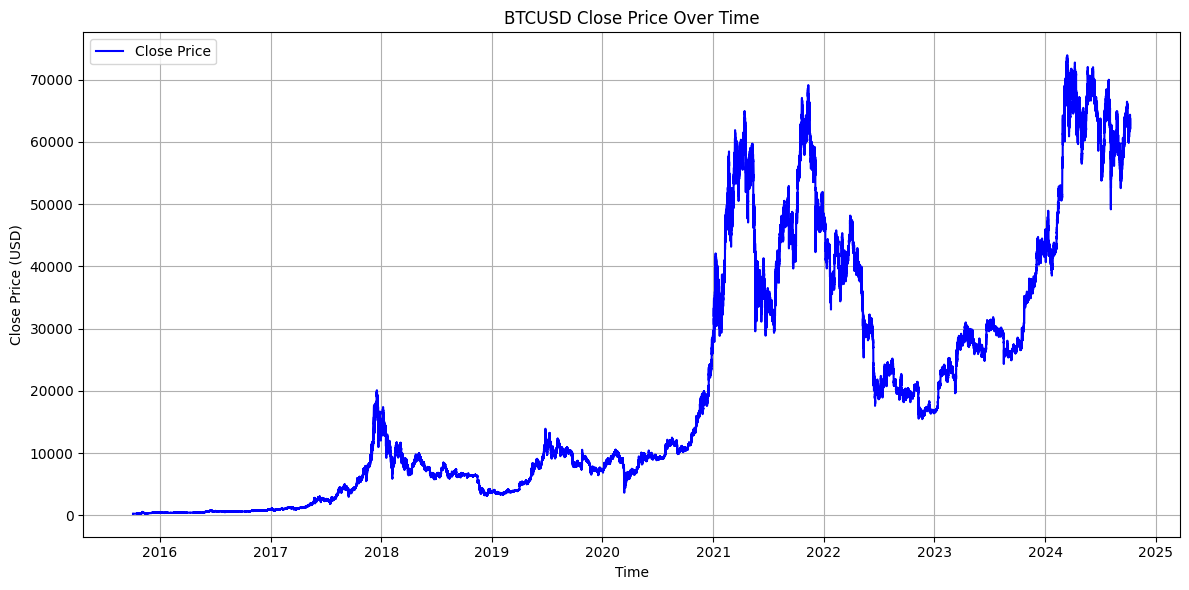

In [14]:
import matplotlib.pyplot as plt

def load_and_plot_close(filepath, title="BTCUSD Close Price Over Time"):
    """
    Load a dataset from a specified file path and plot the 'Close' values over time.
    
    Parameters:
    - filepath: The path to the CSV file to load.
    - title: The title of the plot (default is "BTCUSD Close Price Over Time").
    """
    
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Convert 'Open time' to datetime for proper plotting on the x-axis
    df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce')
    
    # Plot the 'Close' price over time
    plt.figure(figsize=(12, 6))
    plt.plot(df['Open time'], df['Close'], label='Close Price', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Close Price (USD)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Display the plot
    plt.show()

load_and_plot_close('/kaggle/input/comprehensive-btcusd-1m-data/BTCUSD_1m_Combined_Index.csv')